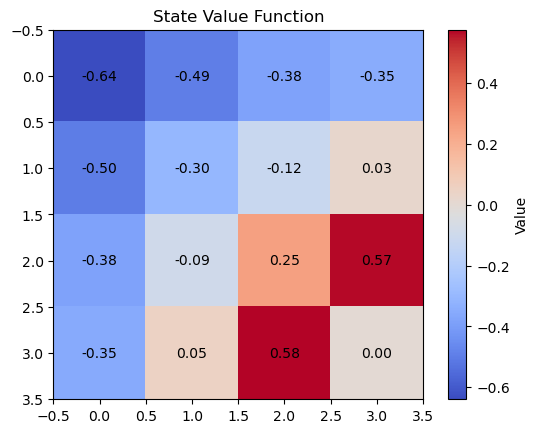

In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Simple 4x4 grid environment for MC prediction
class GridWorldEnv:
    def __init__(self, grid_size=(4, 4), goal_state=(3, 3)):
        self.grid_size = grid_size
        self.goal_state = goal_state
        self.actions = ['up', 'down', 'left', 'right']
        self.reset()

    def reset(self):
        """Reset the environment and return the starting state."""
        self.state = (0, 0)  # Start at top-left corner
        return self.state

    def step(self, action):
        """Take a step in the environment."""
        row, col = self.state

        if action == 'up':
            next_state = (max(row - 1, 0), col)
        elif action == 'down':
            next_state = (min(row + 1, self.grid_size[0] - 1), col)
        elif action == 'left':
            next_state = (row, max(col - 1, 0))
        elif action == 'right':
            next_state = (row, min(col + 1, self.grid_size[1] - 1))
        else:
            raise ValueError(f"Unknown action: {action}")

        self.state = next_state

        # Define rewards: +1 for goal, -0.1 for each step
        if self.state == self.goal_state:
            reward = 1
            done = True
        else:
            reward = -0.1
            done = False

        return next_state, reward, done

    def sample_action(self):
        """Randomly sample an action."""
        return random.choice(self.actions)

# Monte Carlo Prediction with First-Visit
def first_visit_mc_prediction(env, episodes=1000, gamma=0.9):
    # Initialize value function and returns list
    V = defaultdict(float)  # Value function for each state
    returns = defaultdict(list)  # Track all returns for each state

    for ep in range(episodes):
        # Generate an episode
        episode = []
        state = env.reset()
        while True:
            action = env.sample_action()
            next_state, reward, done = env.step(action)
            episode.append((state, reward))
            state = next_state
            if done:
                break
        
        # Calculate returns and update value function (first-visit)
        G = 0  # Initialize the return
        visited_states = set()
        
        # Loop through the episode in reverse order
        for t in range(len(episode) - 1, -1, -1):
            state, reward = episode[t]
            G = reward + gamma * G  # Calculate return
            
            # First-visit: check if state has been visited earlier in this episode
            if state not in visited_states:
                visited_states.add(state)
                returns[state].append(G)  # Store the return for the state
                V[state] = np.mean(returns[state])  # Update value estimate as average of returns

    return V

# Visualizing the state value function in the grid
def plot_value_function(V, grid_size=(4, 4)):
    value_grid = np.zeros(grid_size)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            value_grid[i, j] = V[(i, j)]

    plt.imshow(value_grid, cmap="coolwarm", origin="upper")
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            plt.text(j, i, f'{value_grid[i, j]:.2f}', ha='center', va='center', color='black')
    
    plt.title("State Value Function")
    plt.colorbar(label="Value")
    plt.show()

# Create the environment
env = GridWorldEnv()

# Perform First-Visit Monte Carlo Prediction
V = first_visit_mc_prediction(env, episodes=1000)

# Display the learned value function
plot_value_function(V)


In [8]:
import numpy as np
import random
from collections import defaultdict

class GridWorldEnv:
    def __init__(self, grid_size=(4, 4), goal_state=(3, 3)):
        self.grid_size = grid_size
        self.goal_state = goal_state
        self.actions = ['up', 'down', 'left', 'right']
        self.reset()

    def reset(self):
        """Reset the environment and return the starting state."""
        self.state = (0, 0)  # Start at top-left corner
        return self.state

    def step(self, action):
        """Take a step in the environment."""
        row, col = self.state

        if action == 'up':
            next_state = (max(row - 1, 0), col)
        elif action == 'down':
            next_state = (min(row + 1, self.grid_size[0] - 1), col)
        elif action == 'left':
            next_state = (row, max(col - 1, 0))
        elif action == 'right':
            next_state = (row, min(col + 1, self.grid_size[1] - 1))
        else:
            raise ValueError(f"Unknown action: {action}")

        self.state = next_state

        if self.state == self.goal_state:
            reward = 1  # Reward for reaching the goal
            done = True
        else:
            reward = -0.1  # Small penalty for each step
            done = False

        return next_state, reward, done

    def sample_action(self):
        """Randomly sample an action."""
        return random.choice(self.actions)

def epsilon_greedy_action(state, Q, epsilon, actions):
    """Choose an action using epsilon-greedy."""
    if random.random() < epsilon:
        return random.choice(actions)  # Explore: random action
    else:
        return max(Q[state], key=Q[state].get)  # Exploit: best action based on Q-values

def generate_episode(env, Q, epsilon):
    """Generates an episode using epsilon-greedy policy."""
    episode = []
    state = env.reset()
    while True:
        action = epsilon_greedy_action(state, Q, epsilon, env.actions)
        next_state, reward, done = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def monte_carlo_control(env, episodes=1000, gamma=0.9, epsilon=0.1):
    """Performs Monte Carlo control with epsilon-greedy policy."""
    Q = defaultdict(lambda: {a: 0.0 for a in env.actions})  # Initialize Q-values
    returns = defaultdict(list)  # To store all returns for state-action pairs

    for ep in range(episodes):
        # Generate an episode
        episode = generate_episode(env, Q, epsilon)
        G = 0  # Initialize return

        # Loop backward over the episode
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            G = reward + gamma * G  # Calculate cumulative return

            # First visit Monte Carlo: check if state-action pair was visited earlier in episode
            if (state, action) not in [(x[0], x[1]) for x in episode[:t]]:
                returns[(state, action)].append(G)  # Store return
                Q[state][action] = np.mean(returns[(state, action)])  # Update Q-value

        # Optionally decrease epsilon over time (to reduce exploration)
        epsilon = max(epsilon * 0.99, 0.01)  # Decrease epsilon

    # Extract the optimal policy from Q-values
    policy = {state: max(Q[state], key=Q[state].get) for state in Q}
    return Q, policy

# Initialize environment and run Monte Carlo with epsilon-greedy
env = GridWorldEnv()
Q, optimal_policy = monte_carlo_control(env)

# Display the optimal policy
print("Optimal Policy:")
for state, action in optimal_policy.items():
    print(f"State {state}: Best action -> {action}")

# Display the learned Q-values
print("\nLearned Q-Values:")
for state, actions in Q.items():
    print(f"State {state}: {actions}")


Optimal Policy:
State (0, 0): Best action -> down
State (0, 1): Best action -> down
State (1, 1): Best action -> right
State (0, 2): Best action -> right
State (0, 3): Best action -> down
State (1, 3): Best action -> down
State (1, 2): Best action -> down
State (2, 3): Best action -> down
State (2, 2): Best action -> right
State (1, 0): Best action -> right
State (2, 0): Best action -> right
State (2, 1): Best action -> down
State (3, 0): Best action -> up
State (3, 1): Best action -> right
State (3, 2): Best action -> right

Learned Q-Values:
State (0, 0): {'up': -0.36918650060780034, 'down': 0.16357620687307062, 'left': -0.20283849999999978, 'right': -0.7047549991805321}
State (0, 1): {'up': -0.9999999987859735, 'down': -0.4751199976788043, 'left': -0.9999999999999994, 'right': -0.9999999999999994}
State (1, 1): {'up': -0.6063399999999995, 'down': -0.27099999999999963, 'left': -0.2460809875112374, 'right': 0.44725180993927144}
State (0, 2): {'up': -0.8764653207432103, 'down': -0.9999